## import thư viện

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math
from sklearn.preprocessing import MinMaxScaler

from scipy import stats

In [4]:
sns.set_style("whitegrid")

## data reading

In [5]:
df = pd.read_csv('/content/drive/MyDrive/DS111/Do an/final_data.csv')
df.head()

,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Location,Origin,Associated Types,OFDA Response,Appeal,AID Contribution ('000 US$),...,Total Affected,Total Damage ('000 US$),"Total Damage, Adjusted ('000 US$)",CPI,Admin Units,Entry Date,Last Update,economic_region,Start Date,End Date
0,Natural,Meteorological,Storm,Tropical cyclone,Southern coast,Unknow,No,No,No,NaN,...,0.0,0.0,0.0,9.156133,NaN,2006-09-17,2023-09-25,['Ngoại lệ'],1953-09-26,1953-09-26
1,Natural,Meteorological,Storm,Tropical cyclone,NaN,Unknow,No,No,No,NaN,...,0.0,0.0,0.0,9.288532,NaN,2003-07-01,2023-09-25,['Ngoại lệ'],NaN,NaN
2,Natural,Biological,Epidemic,Bacterial disease,"Saigon, Mekong delta",Unknow,No,Yes,No,NaN,...,10848.0,0.0,0.0,10.598376,NaN,2003-07-01,2023-09-25,"['Vùng Đông Nam Bộ', 'Vùng đồng bằng sông Cửu ...",1964-01-01,1964-01-01
3,Natural,Meteorological,Storm,Tropical cyclone,China sea coast,Unknow,No,Yes,No,NaN,...,700000.0,50000.0,471770.0,10.598376,NaN,2006-09-17,2023-09-25,['Ngoại lệ'],NaN,NaN
4,Natural,Hydrological,Flood,Flood (General),NaN,Unknow,No,No,No,NaN,...,0.0,0.0,0.0,10.598376,NaN,2003-07-01,2023-09-25,['Ngoại lệ'],NaN,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335 entries, 0 to 334
Data columns (total 33 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Disaster Group                     335 non-null    object 
 1   Disaster Subgroup                  335 non-null    object 
 2   Disaster Type                      335 non-null    object 
 3   Disaster Subtype                   335 non-null    object 
 4   Location                           317 non-null    object 
 5   Origin                             335 non-null    object 
 6   Associated Types                   335 non-null    object 
 7   OFDA Response                      335 non-null    object 
 8   Appeal                             335 non-null    object 
 9   AID Contribution ('000 US$)        20 non-null     float64
 10  Magnitude                          90 non-null     float64
 11  Magnitude Scale                    268 non-null    object 

# 1. Thiệt hại về người và kinh tế ngày càng tăng

Biểu đồ cột chồng thể hiện tổng thiệt hại của cả Total Affected, Total Deaths, Total Damage Adjusted theo thập kỷ

In [7]:
df['Decade'] = (df['Start Year'] // 10) * 10
# chuẩn bị dữ liệu
decade_df = (
    df.groupby('Decade')[[
        'Total Affected',
        'Total Deaths',
        "Total Damage, Adjusted ('000 US$)"
    ]]
    .sum()
    .reset_index()
)

metrics = [
    'Total Affected',
    'Total Deaths',
    "Total Damage, Adjusted ('000 US$)"
]
decade_norm = decade_df.copy()
for col in metrics:
    decade_norm[col] = decade_df[col] / decade_df[col].max()

In [8]:
decade_norm

,Decade,Total Affected,Total Deaths,"Total Damage, Adjusted ('000 US$)"
0,1950,0.000000,0.116274,0.000000
1,1960,0.026912,0.884387,0.032612
2,1970,0.132351,0.076525,0.000000
3,1980,1.000000,0.503523,0.002855
4,1990,0.509617,1.000000,0.282298
5,2000,0.617446,0.449020,0.422731
6,2010,0.529457,0.182559,1.000000
7,2020,0.094218,0.060009,0.100027


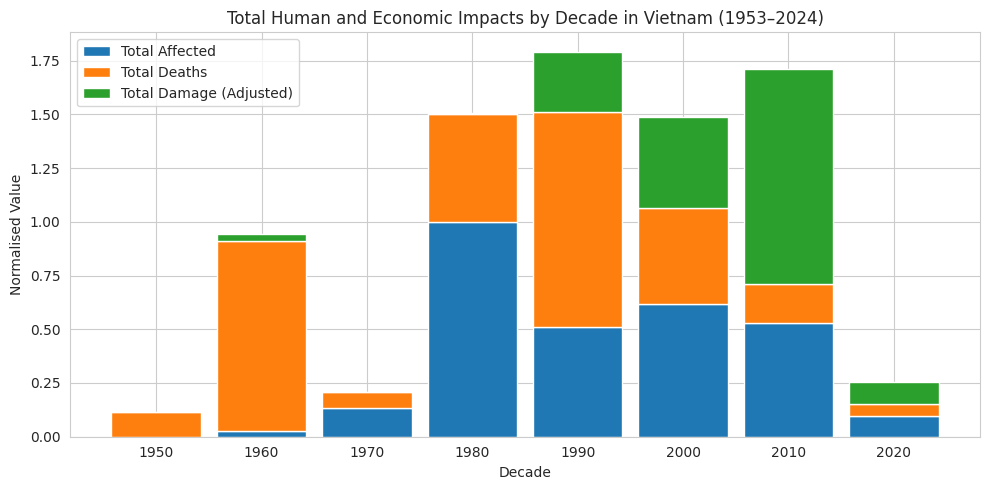

In [9]:
# vẽ biểu đồ cột chồng để so sánh tổng thiệt hại về người và kinh tế
sns.set_style("whitegrid")

# Tạo trục x dạng số
x = np.arange(len(decade_norm))
bar_width = 0.85

plt.figure(figsize=(10, 5))

plt.bar(
    x,
    decade_norm['Total Affected'],
    width=bar_width,
    label='Total Affected'
)

plt.bar(
    x,
    decade_norm['Total Deaths'],
    bottom=decade_norm['Total Affected'],
    width=bar_width,
    label='Total Deaths'
)

plt.bar(
    x,
    decade_norm["Total Damage, Adjusted ('000 US$)"],
    bottom=(
        decade_norm['Total Affected'] +
        decade_norm['Total Deaths']
    ),
    width=bar_width,
    label="Total Damage (Adjusted)"
)

plt.xticks(x, decade_norm['Decade'])
plt.xlabel('Decade')
plt.ylabel('Normalised Value')
plt.title('Total Human and Economic Impacts by Decade in Vietnam (1953–2024)')
plt.legend()
plt.tight_layout()
plt.show()


> Tổng thiệt hại về người và kinh tế ngày càng tăng cho thấy thảm họa ngày càng nguy hiểm

Biểu đồ cột ghép thể hiện thiệt hại của Total Affected, Total Deaths, Total Damage Adjusted

In [10]:
impact_by_decade = (
    df.groupby('Decade')
      .agg(
          Total_Deaths=('Total Deaths', 'sum'),
          Total_Affected=('Total Affected', lambda x: x.sum() / 1000),  # thousands
          Total_Damage_Adjusted=("Total Damage, Adjusted ('000 US$)", lambda x: x.sum() / 1000)  # millions USD
      )
      .reset_index()
)

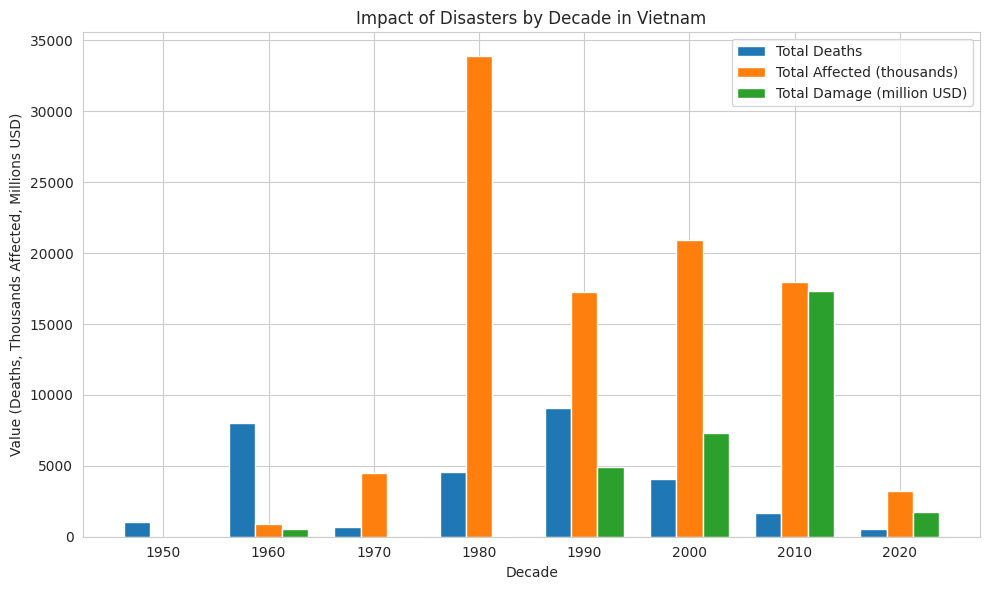

In [11]:
# Data
types = impact_by_decade['Decade']
x = np.arange(len(types))
bar_width = 0.25

# Values
deaths = impact_by_decade['Total_Deaths']
affected = impact_by_decade['Total_Affected']
damage = impact_by_decade['Total_Damage_Adjusted']

# Plot
plt.figure(figsize=(10, 6))

plt.bar(x - bar_width, deaths, width=bar_width, label='Total Deaths')
plt.bar(x, affected, width=bar_width, label='Total Affected (thousands)')
plt.bar(x + bar_width, damage, width=bar_width, label='Total Damage (million USD)')

plt.xticks(x, types)
plt.xlabel('Decade')
plt.ylabel('Value (Deaths, Thousands Affected, Millions USD)')
plt.title('Impact of Disasters by Decade in Vietnam')
plt.legend()
plt.tight_layout()
plt.show()

Biểu đồ đường thể hiện chi tiết thiệt hại qua từng năm

In [12]:
year_df = (
    df.groupby('Start Year')
      .agg(
          Total_Deaths=('Total Deaths', 'sum'),
          Total_Affected=('Total Affected', 'sum'),
          Total_Damage_Adjusted=("Total Damage, Adjusted ('000 US$)", 'sum')
      )
      .reset_index()
)

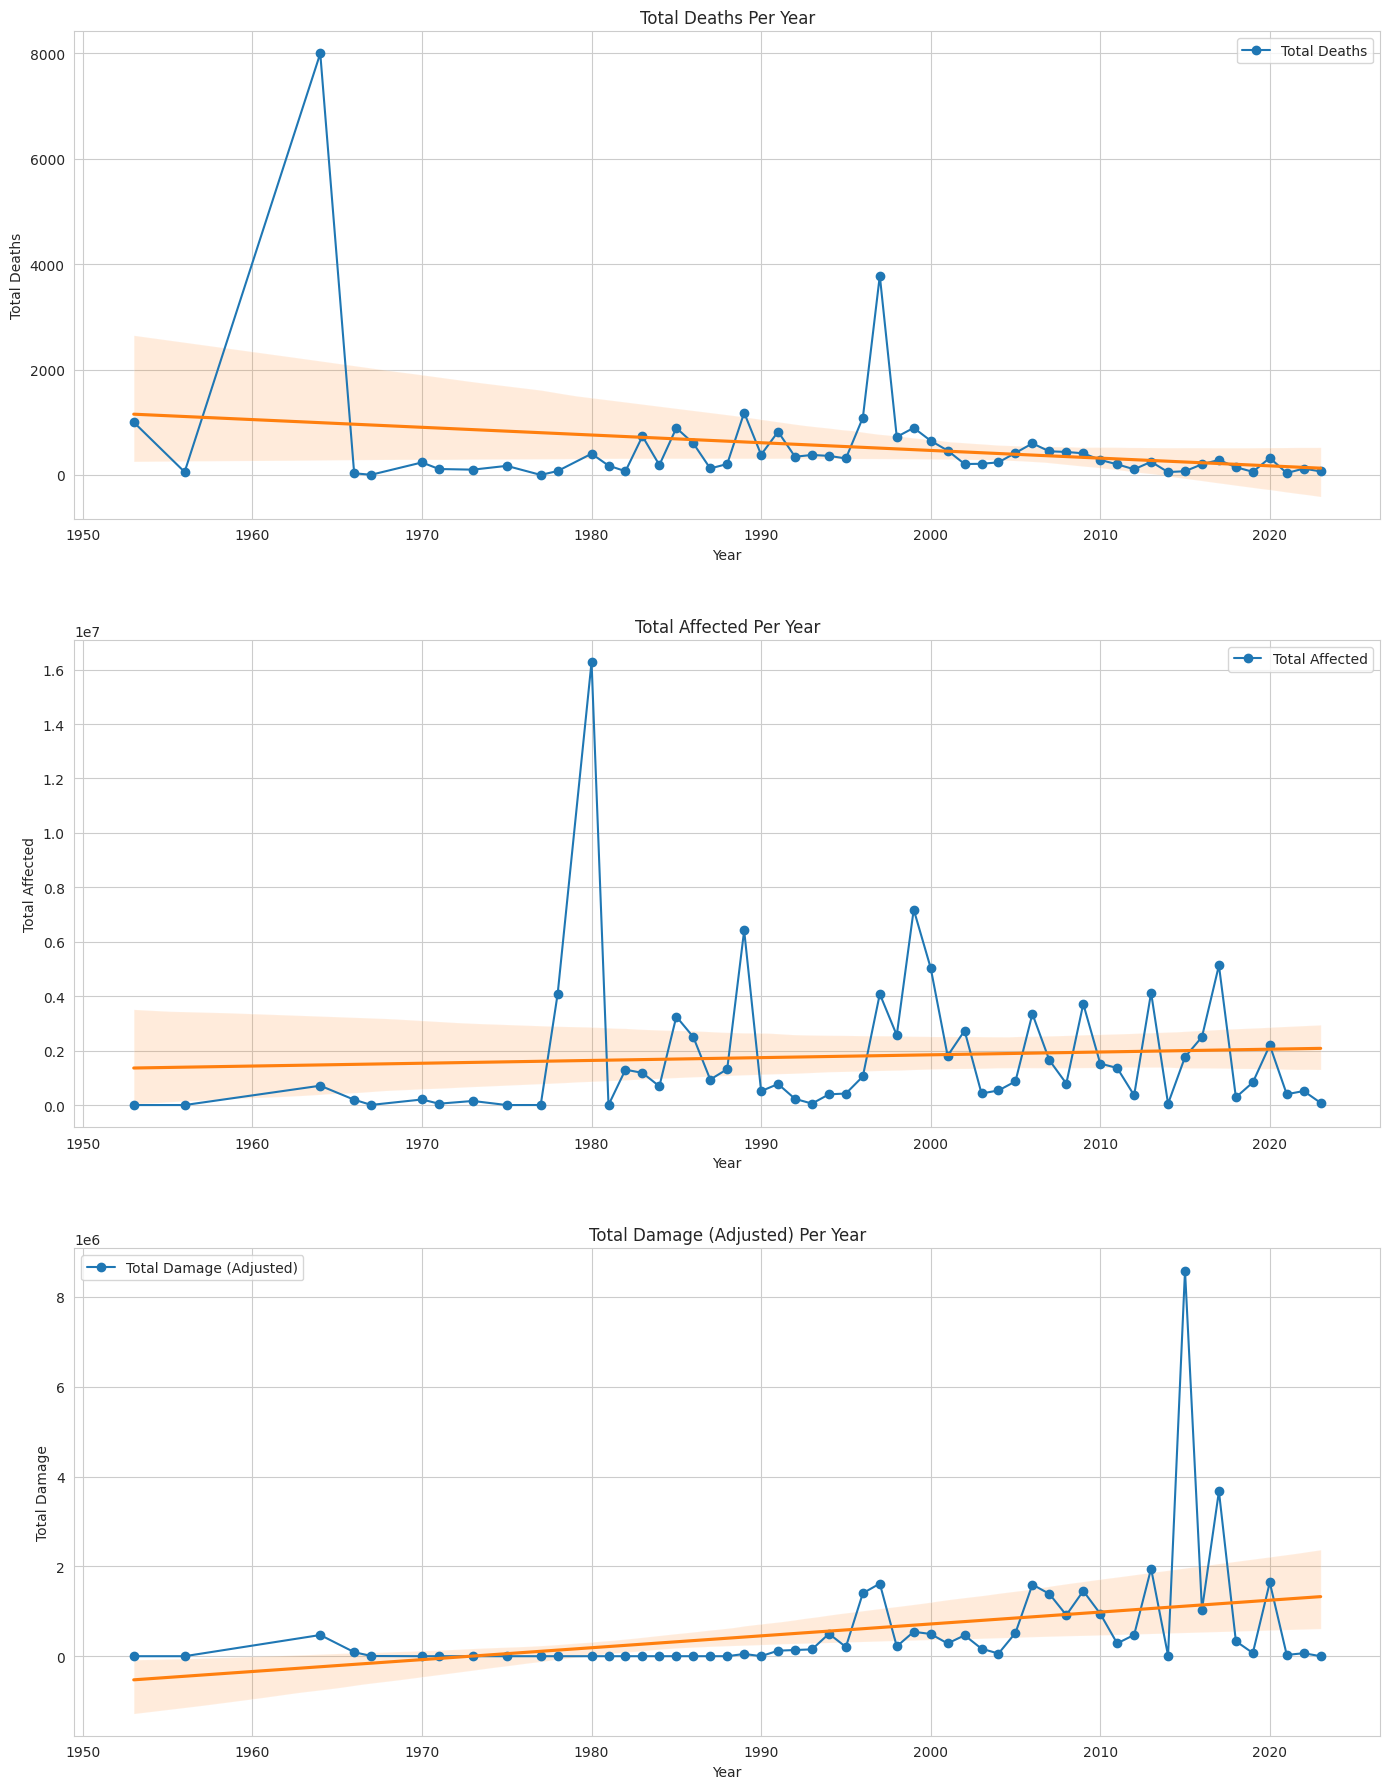

In [13]:
plt.figure(figsize=(14, 18))

# Total Deaths
plt.subplot(3, 1, 1)
plt.plot(
    year_df['Start Year'],
    year_df['Total_Deaths'],
    marker='o',
    label='Total Deaths'
)
sns.regplot(
    data=year_df,
    x='Start Year',
    y='Total_Deaths',
    scatter=False
)
plt.ylabel('Total Deaths')
plt.xlabel('Year')
plt.title('Total Deaths Per Year')
plt.legend()

# Total Affected
plt.subplot(3, 1, 2)
plt.plot(
    year_df['Start Year'],
    year_df['Total_Affected'],
    marker='o',
    label='Total Affected'
)

sns.regplot(
    data=year_df,
    x='Start Year',
    y='Total_Affected',
    scatter=False
)
plt.ylabel('Total Affected')
plt.xlabel('Year')
plt.title('Total Affected Per Year')
plt.legend()

# Total Damage
plt.subplot(3, 1, 3)
plt.plot(
    year_df['Start Year'],
    year_df['Total_Damage_Adjusted'],
    marker='o',
    label="Total Damage (Adjusted)"
)

sns.regplot(
    data=year_df,
    x='Start Year',
    y='Total_Damage_Adjusted',
    scatter=False
)
plt.ylabel('Total Damage')
plt.xlabel('Year')
plt.title('Total Damage (Adjusted) Per Year')
plt.legend()

plt.tight_layout(h_pad=4)
plt.show()

> Thông qua biểu đồ cột ghép và biểu đồ Regplot:
- Số người chết ngày càng giảm cho thấy hệ thống cảnh báo và sự chuẩn bị của mọi người ngày càng tốt

- Số lượng người bị ảnh hưởng có xu hướng tăng nhẹ cũng cho thấy sự nguy hiểm ngày càng gia tăng của các thảm họa.

- Thiệt hại kinh tế ngày càng tăng phản ánh việc cơ sở hạ tầng đã ngày càng được mở rộng và xây dựng thêm dẫn đến mỗi khi thảm họa ập đến thì thiệt hại là khá lớn.

# 2. Loại thảm họa gây thiệt hại nặng nhất là Bão và lũ lụt

Bảng thống kê tổng thiệt hại của từng loại thảm họa

In [14]:
# bảng thống kê tổng thiệt hại của từng loại thảm họa
impact_by_type = (
    df.groupby('Disaster Type')
      .agg(
          Total_Deaths=('Total Deaths', 'sum'),
          Total_Affected=('Total Affected', 'sum'),
          Total_Damage_Adjusted=("Total Damage, Adjusted ('000 US$)", 'sum')
      )
      .reset_index()
)

impact_by_type.sort_values(by='Total_Deaths', ascending=False)

,Disaster Type,Total_Deaths,Total_Affected,Total_Damage_Adjusted
16,Storm,19727.0,56380455.0,15955320.0
9,Flood,6073.0,33501230.0,6525572.0
4,Epidemic,1167.0,107907.0,0.0
17,Water,609.0,75.0,0.0
15,Road,468.0,225.0,0.0
1,Collapse (Industrial),453.0,80.0,2823.0
11,Mass movement (wet),330.0,39074.0,4541.0
0,Air,269.0,5.0,0.0
8,Fire (Miscellaneous),177.0,5138.0,7641.0
13,Poisoning,177.0,964.0,0.0


Biểu đồ cột chồng thể hiện tổng thiệt hại của từng loại thảm họa

In [15]:
# chuẩn bị dữ liệu
DisasterType_df = (
    df.groupby('Disaster Type')[[
        'Total Affected',
        'Total Deaths',
        "Total Damage, Adjusted ('000 US$)"
    ]]
    .sum()
    .reset_index()
)

metrics = [
    'Total Affected',
    'Total Deaths',
    "Total Damage, Adjusted ('000 US$)"
]
DisasterType_norm = DisasterType_df.copy()
for col in metrics:
    DisasterType_norm[col] = DisasterType_df[col] / DisasterType_df[col].max()

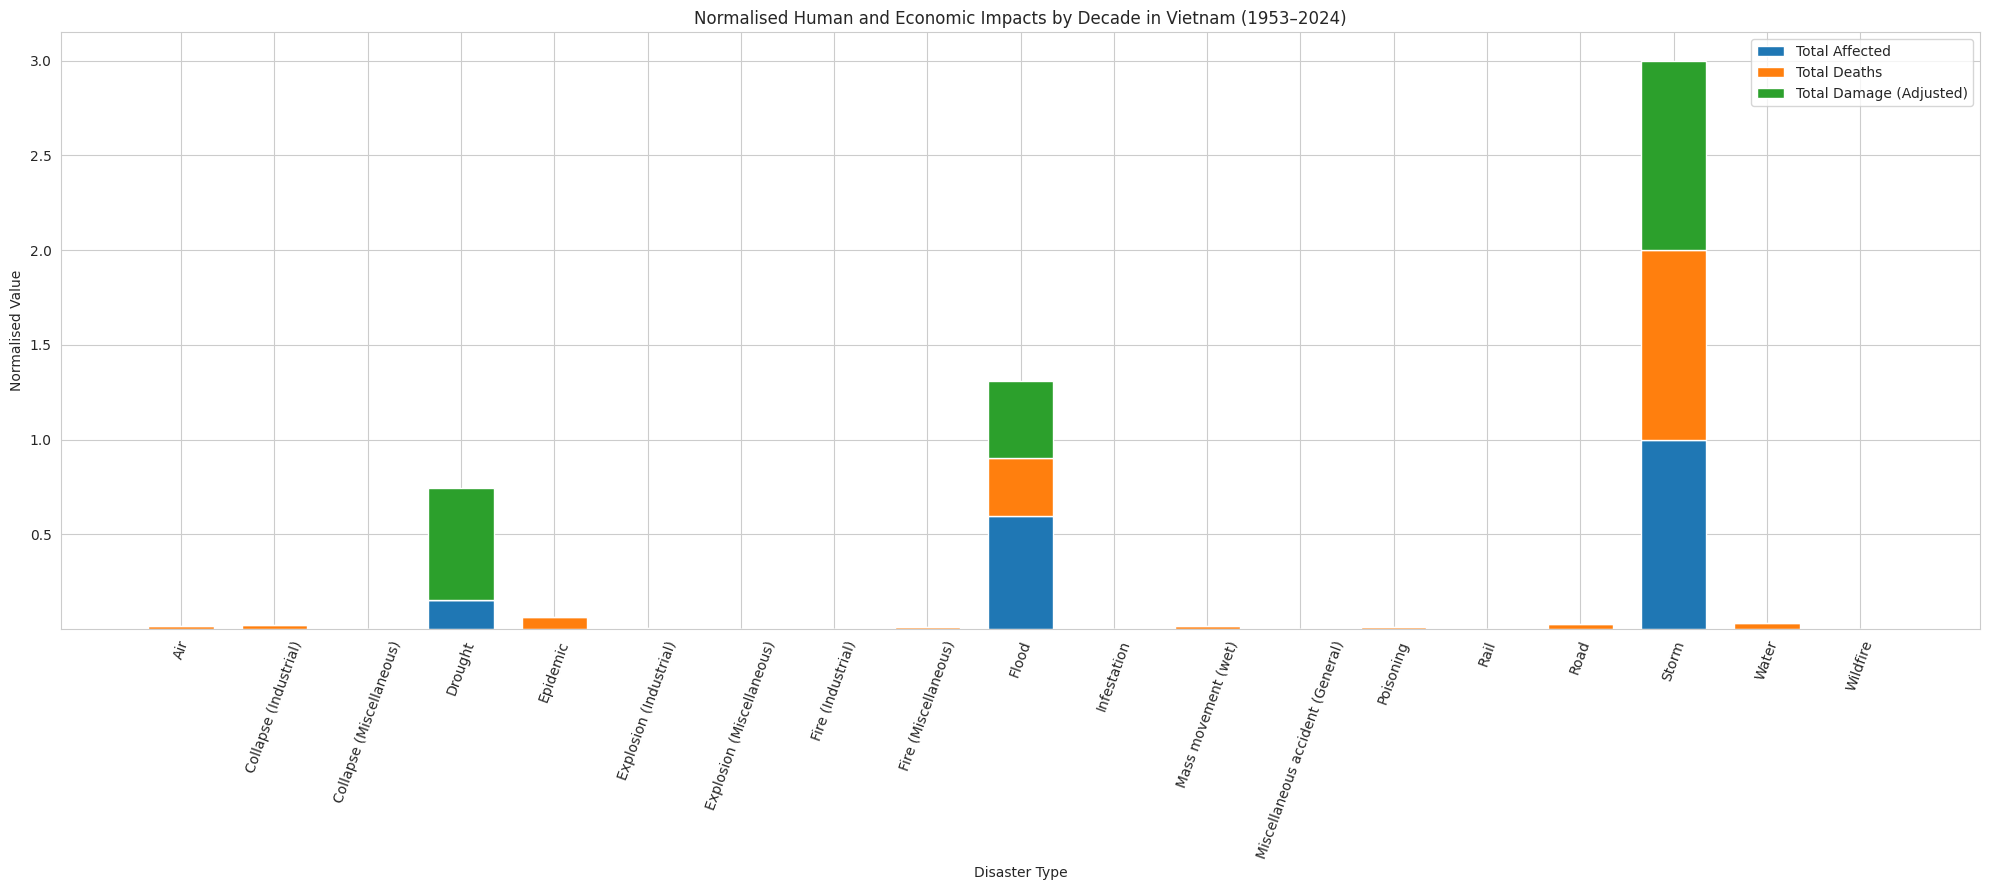

In [16]:
# vẽ biểu đồ cột chồng để so sánh tổng thiệt hại về người và kinh tế
x = np.arange(len(DisasterType_norm))
bar_width = 0.70
plt.figure(figsize=(20, 9))

plt.bar(
    x,
    DisasterType_norm['Total Affected'],
    width=bar_width,
    label='Total Affected'
)

plt.bar(
    x,
    DisasterType_norm['Total Deaths'],
    bottom=DisasterType_norm['Total Affected'],
    width=bar_width,
    label='Total Deaths'
)

plt.bar(
    x,
    DisasterType_norm["Total Damage, Adjusted ('000 US$)"],
    bottom=(
        DisasterType_norm['Total Affected'] +
        DisasterType_norm['Total Deaths']
    ),
    width=bar_width,
    label="Total Damage (Adjusted)"
)

plt.xticks(x, DisasterType_norm['Disaster Type'])
plt.xlabel('Disaster Type')
plt.ylabel('Normalised Value')
plt.title('Normalised Human and Economic Impacts by Decade in Vietnam (1953–2024)')
plt.xticks(rotation=70)
plt.legend()
plt.tight_layout()
plt.show()

Biểu đồ cột ghép thể hiện thiệt hại của từng loại thảm họa

In [17]:
impact_by_type = (
    df.groupby('Disaster Type')
      .agg(
          Total_Deaths=('Total Deaths', 'sum'),
          Total_Affected=('Total Affected', lambda x: x.sum() / 1000),  # thousands
          Total_Damage_Adjusted=("Total Damage, Adjusted ('000 US$)", lambda x: x.sum() / 1000)  # millions USD
      )
      .reset_index()
)

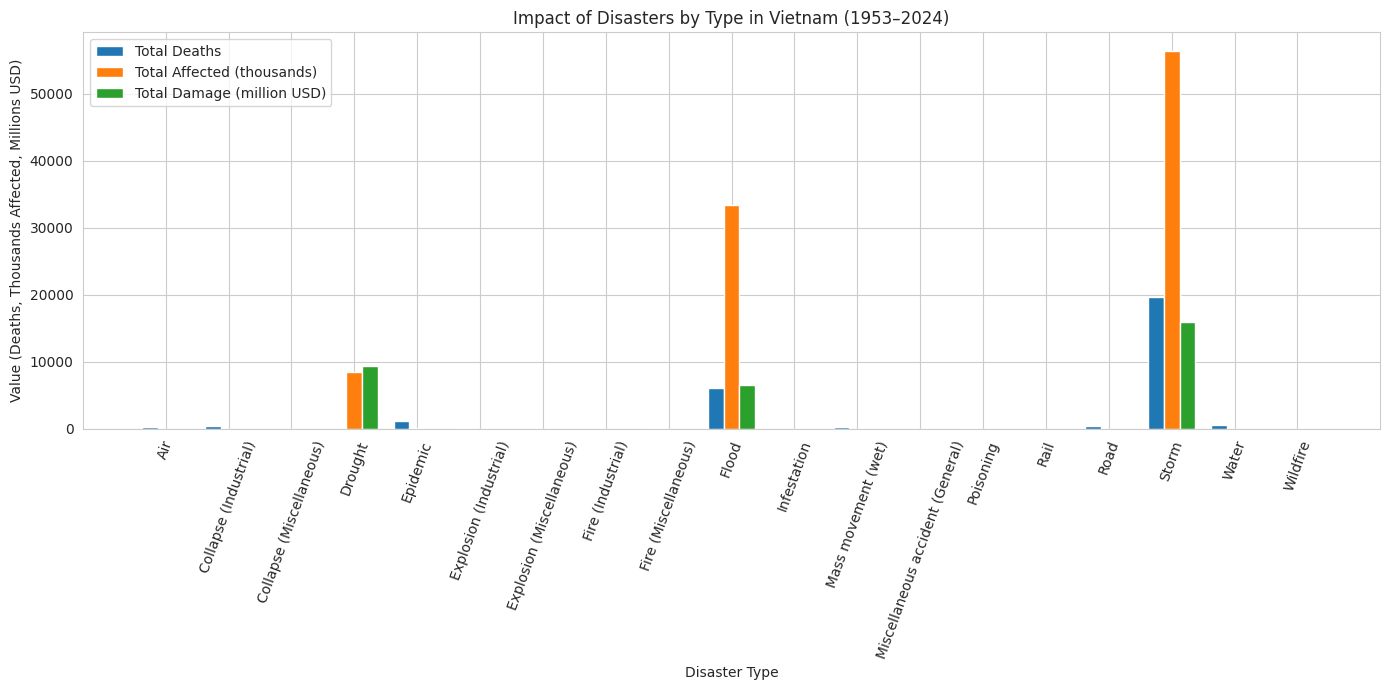

In [18]:
# Data
types = impact_by_type['Disaster Type']
x = np.arange(len(types))
bar_width = 0.25

# Values
deaths = impact_by_type['Total_Deaths']
affected = impact_by_type['Total_Affected']
damage = impact_by_type['Total_Damage_Adjusted']

# Plot
plt.figure(figsize=(14, 7))

plt.bar(x - bar_width, deaths, width=bar_width, label='Total Deaths')
plt.bar(x, affected, width=bar_width, label='Total Affected (thousands)')
plt.bar(x + bar_width, damage, width=bar_width, label='Total Damage (million USD)')

plt.xticks(x, types, rotation=70)
plt.xlabel('Disaster Type')
plt.ylabel('Value (Deaths, Thousands Affected, Millions USD)')
plt.title('Impact of Disasters by Type in Vietnam (1953–2024)')

plt.legend()
plt.tight_layout()
plt.show()

- Thiệt hại về người và kinh tế chủ yếu gây ra bởi bão và lũ.

- Đối với bão, lũ thì số lượng người bị ảnh hưởng là rất lớn

- Hạn hán cũng gây ra thiệt hại kinh tế tương xứng với số người bị ảnh hưởng cho thấy đây cũng là một thảm họa đáng lo ngại

# 3. Tương quan qua lại giữa các thiệt hại về người và kinh tế


Heatmap thể hiện tương quan giữa các thiệt hại (1953 - 2024)

In [19]:
cols = [
    'Total Affected',
    'Total Deaths',
    "Total Damage, Adjusted ('000 US$)"
]
corr_df = df[cols].copy()
corr_matrix = corr_df.corr(method='pearson')

metric_names = {
    'Total Affected': 'Total Affected',
    'Total Deaths': 'Total Deaths',
    "Total Damage, Adjusted ('000 US$)": 'Total Damage'
}
corr_matrix = corr_matrix.rename(index=metric_names, columns=metric_names)

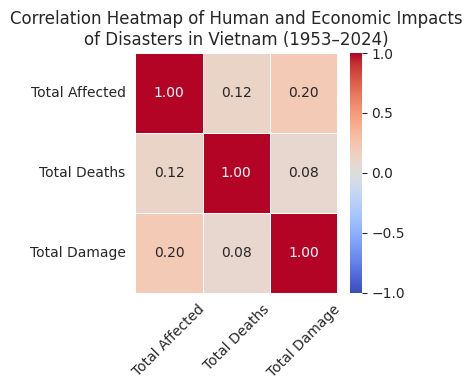

In [20]:
plt.figure(figsize=(4, 4))

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    vmin=-1,
    vmax=1,
    cbar_kws={"ticks": [-1, -0.5, 0, 0.5, 1]}
)

plt.title(
    'Correlation Heatmap of Human and Economic Impacts\n'
    'of Disasters in Vietnam (1953–2024)'
)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Heatmap thể hiện tương quan qua lại giữa các thiệt hại theo từng thập kỷ

In [21]:
# chuẩn bị dữ liệu
df['Decade'] = (df['Start Year'] // 10) * 10
decades = []
for d in sorted(df['Decade'].dropna().unique()):
    if len(df[df['Decade'] == d]) >= 10:
        decades.append(d)

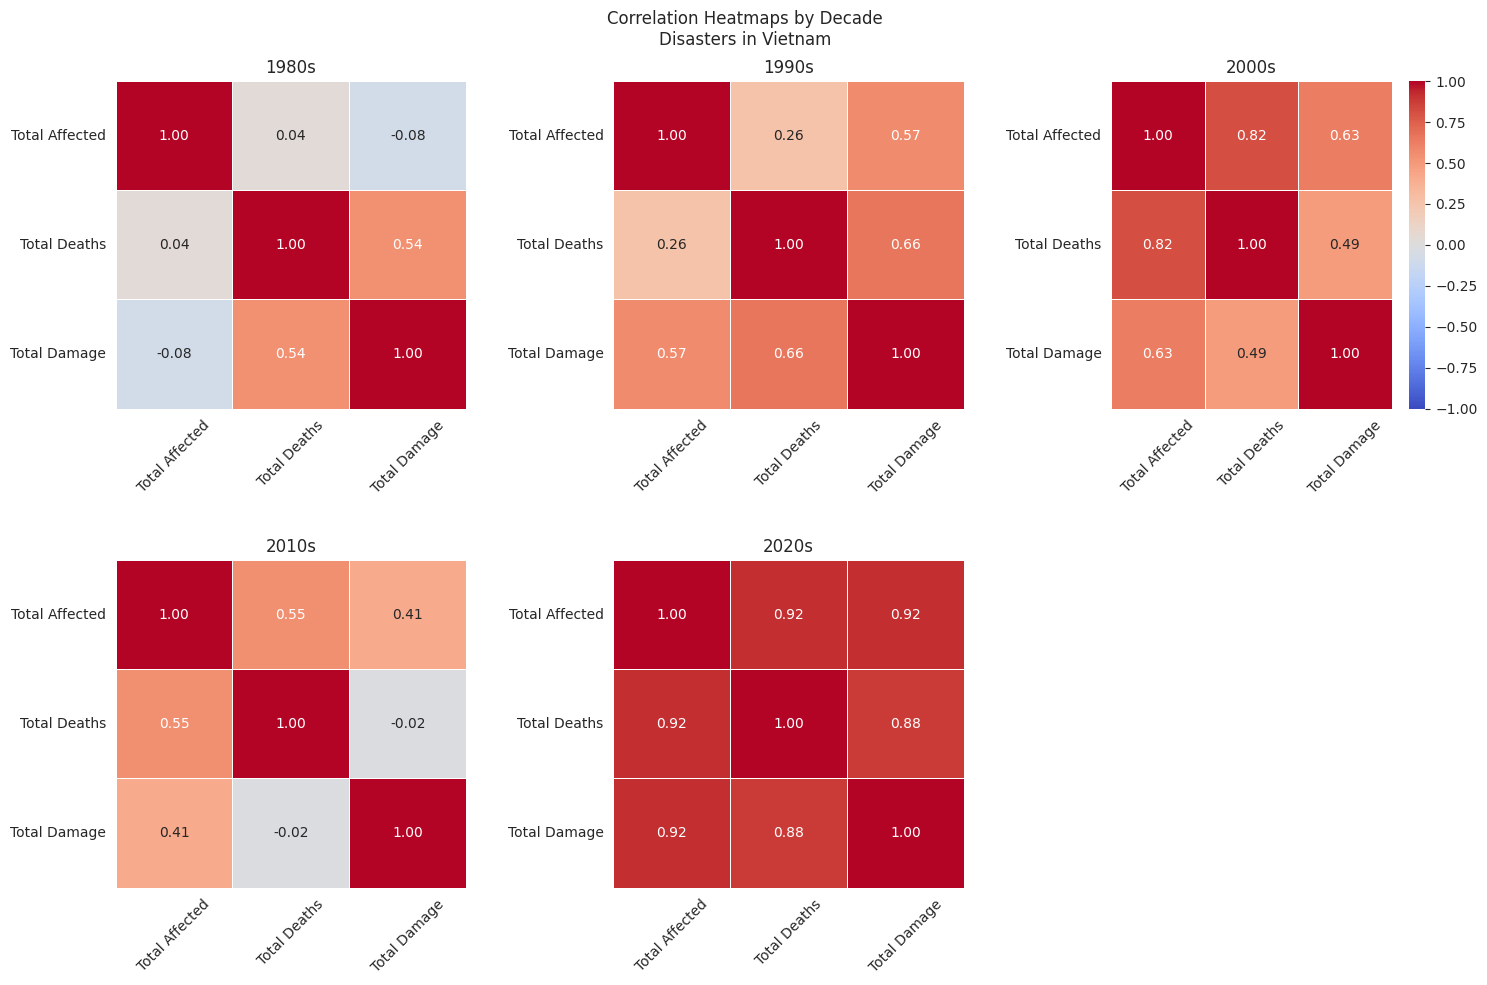

In [22]:
cols = [
    'Total Affected',
    'Total Deaths',
    "Total Damage, Adjusted ('000 US$)"
]

metric_names = {
    'Total Affected': 'Total Affected',
    'Total Deaths': 'Total Deaths',
    "Total Damage, Adjusted ('000 US$)": 'Total Damage'
}

plt.figure(figsize=(15, 10))
for i, decade in enumerate(decades):
    plt.subplot(2, 3, i + 1)

    df_decade = df[df['Decade'] == decade]
    corr_df = df_decade[cols]
    corr_matrix = corr_df.corr(method='pearson')
    corr_matrix = corr_matrix.rename(
        index=metric_names,
        columns=metric_names
    )

    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        vmin=-1,
        vmax=1,
        linewidths=0.5,
        cbar=(i==2)
    )

    plt.title(f'{decade}s')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

plt.suptitle(
    'Correlation Heatmaps by Decade\n'
    'Disasters in Vietnam'
)

plt.tight_layout(h_pad=3, w_pad=3)
plt.show()


> Qua nhiều thập kỷ, mối tương quan có xu hướng tăng rõ rệt, đặc biệt là giữa Tổng số người bị ảnh hưởng và Tổng thiệt hại kinh tế, cho thấy rằng các thảm họa ngày càng tác động đồng thời đến cả con người và tài sản kinh tế.